In [1]:
# Import Libraries
import io
import math 
import os
from glob import glob

import earthpy as et
import earthpy.appeears as etapp
# import earthpy.earthexplorer as etee
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
from xrspatial import aspect
from xrspatial import slope

In [2]:
# Create data directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final_project')
if not os.path.exists(data_dir):
        os.makedirs(data_dir)

# Get original working directory
owd = os.getcwd()

# Make data directory the working directory
os.chdir(data_dir)

# Define utm zone
utm = 32613

In [3]:
# Code adapted from: https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
# Create directory
grassland_url = ('https://data.fs.usda.gov/geodata/edw/'
                 'edw_resources/shp/S_USA.NationalGrassland.zip'
)
print('Downloading shapefile...')

# Request data from url
grassland_request = requests.get(grassland_url)
grassland_zip = zipfile.ZipFile(io.BytesIO(grassland_request.content))

# Extract files from zip and save to directory
grassland_zip.extractall(
    path=os.path.join(data_dir, 'national-grassland')
    )
print('Done')

Done


In [4]:
# Import shapefile
grassland_gdf = gpd.read_file(os.path.join(
    data_dir, 'national-grassland', 'S_USA.NationalGrassland.shp')
    )

# Get selected grasslands
select_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Comanche National Grassland', 'Pawnee National Grassland']]
)

In [5]:
def get_polaris_data(data_directory, input_gdf, index_col_name):
    """
    This function downloads Polaris soil data for the extent of each 
    row in a geodataframe and creates a merged data array for each. 
    Downloaded data is saved in individual folders for each row. Merged 
    data arrays for each row are saved in "Merged_files" subfolder.

    Attributes
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads. 

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in 
        the dataframe. 
    
    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.
    
    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """

    # Set index to specified index column
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    file_list = []
    
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = math.floor(bound_pd['minx'][ind])
        max_lon = math.ceil(bound_pd['maxx'][ind])
        min_lat = math.floor(bound_pd['miny'][ind])
        max_lat = math.ceil(bound_pd['maxy'][ind])
        # Define range
        lat_range = range(min_lat,max_lat)
        lon_range = range(min_lon,max_lon)

        # Create template for polaris url path
        polaris_template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                    '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
        # Create template for file names
        polaris_template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'

        # Create sub-directory for soil data
        soil_dir = os.path.join(data_directory, "soil_data")
        if not os.path.exists(soil_dir):
            os.makedirs(soil_dir)

        # Create sub-folders for each row's data
        soil_row_dir = os.path.join(soil_dir, str(ind).replace(" ", "_"))
        if not os.path.exists(soil_row_dir):
            os.makedirs(soil_row_dir)
        
        # Create sub-folder for merged data arrays
        soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
        if not os.path.exists(soil_merged_dir):
            os.makedirs(soil_merged_dir)
        
        # For each latitude and longitude in the extent, download file
        for lat in lat_range:
            for lon in lon_range:
                # Define url for each data file in extent
                url = polaris_template_url.format('ph',
                                        'mean',
                                        '60_100',
                                        str(lat),
                                        str(lat+1),
                                        str(lon),
                                        str(lon+1))
                # Define file name for each data file in extent
                file_name = polaris_template_name.format(str(lat),
                                        str(lat+1),
                                        str(lon),
                                        str(lon+1))
                # Check if tif file is in directory. Download if not.
                file_name_path = os.path.join(soil_row_dir, file_name)
                if not os.path.exists(file_name_path): 
                    print(file_name, "does not exist. Downloading file")
                    r = requests.get(url, allow_redirects=True)
                    open(file_name_path, 'wb').write(r.content)
                else:
                    print(file_name, "is already downloaded")

        # Merge arrays if the merged file does not exist
        merge_template_name = '{0}_merged_da.tif'
        merge_da_name = merge_template_name.format(str(ind).replace(" ", "_"), ".tif")
        if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)): 
            print("Soil data is being merged.")
            tif_paths = glob(os.path.join(soil_row_dir, '*.tif'))
            das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
            merged_da = rxrmerge.merge_arrays(das)
            merged_da.rio.to_raster(
                os.path.join(soil_merged_dir, merge_da_name)
                )
            print("Merged soil file created.")
        else:
            print("A merged soil data array already exists.")
            merged_da = rxr.open_rasterio(
                os.path.join(soil_merged_dir, merge_da_name), masked=True
                )
        
        # Add file to list of tif files to return
        file_list.append(os.path.join(soil_merged_dir, merge_da_name))
        
    # Return files
    output_lst = [rxr.open_rasterio(tif, masked=True).squeeze() for tif in file_list]
    return output_lst

comanche_pH_da, pawnee_pH_da = get_polaris_data(data_dir, select_grassland_gdf, "GRASSLANDN")


 Comanche National Grassland :
mean_ph_lat3637_lon-105-104.tif does not exist. Downloading file


mean_ph_lat3637_lon-104-103.tif does not exist. Downloading file
mean_ph_lat3637_lon-103-102.tif does not exist. Downloading file
mean_ph_lat3738_lon-105-104.tif does not exist. Downloading file
mean_ph_lat3738_lon-104-103.tif does not exist. Downloading file
mean_ph_lat3738_lon-103-102.tif does not exist. Downloading file
Soil data is being merged.
Merged soil file created.

 Pawnee National Grassland :
mean_ph_lat4041_lon-105-104.tif does not exist. Downloading file
mean_ph_lat4041_lon-104-103.tif does not exist. Downloading file
mean_ph_lat4142_lon-105-104.tif does not exist. Downloading file
mean_ph_lat4142_lon-104-103.tif does not exist. Downloading file
Soil data is being merged.
Merged soil file created.


In [6]:
# Change projection of grassland data
select_grassland_utm_gdf = select_grassland_gdf.to_crs(utm)

# Clip pH files to bounds
comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *select_grassland_utm_gdf
                      .loc[['Comanche National Grassland']]
                      .total_bounds)
)
pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *select_grassland_utm_gdf
                      .loc[['Pawnee National Grassland']]
                      .total_bounds)
)

In [7]:
pawnee_ph_plt = (
    pawnee_pH_da.hvplot(cmap="bgy") 
    * select_grassland_utm_gdf
    .loc[['Pawnee National Grassland']]
    .hvplot(line_width=1, line_color='white', color=None)
).opts(
    xaxis=None,
    yaxis=None,
    title = "Soil pH at 60-100cm depth"
)

comanche_ph_plt = (
    comanche_pH_da.hvplot(cmap="bgy") 
    * select_grassland_utm_gdf
    .loc[['Comanche National Grassland']]
    .hvplot(line_width=1, line_color='white', color=None)
).opts(
    xaxis=None,
    yaxis=None,
    title = "Soil pH at 60-100cm depth"
)

In [8]:
# Change crs of selected grasslands
select_grassland_gdf = select_grassland_gdf.to_crs(4326)

# Download AppEEARS SRTM DEM data for full extent
elevation_downloader = etapp.AppeearsDownloader(
    download_key="SRTM_DEM",
    ea_dir=data_dir,
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11",
    end_date="02-21",
    recurring=True,
    year_range=[2000,2000],
    polygon=select_grassland_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(elevation_downloader.data_dir):
    elevation_downloader.download_files()

In [9]:
# Read elevation data.
for tif in glob(os.path.join(data_dir, 'SRTM_DEM',
                'SRTMGL1_NC*',
                '*.tif')):
    elev_da = rxr.open_rasterio(tif, masked=True).squeeze()
    elev_da.name = 'Elevation'

In [10]:
def clip_and_reproj_match(in_da, clip_gdf, match_da):
    """
    This function clips a data array to a specificed extent and 
    harmonizes the array to match another data array.

    Parameters
    ----------
    in_da: xarray.DataArray
        Represents the data array that is to be clipped and reprojected

    clip_gdf: geopandas.GeoDataFrame
        The geodataframe to which the data input area should be clipped

    match_da: xarray.DataArray
        The data array for which the input data array should be 
        reprojected to match the resolution, projection, and region

    Returns
    ----------
    clip_da: xarray.DataArray
        A clipped and harmonized version of the input data array
    """
    # Clip to extent of input and reproject match to specified array
    clip_da = (in_da
                  .rio.clip_box(*clip_gdf.to_crs(in_da.rio.crs)
                                .total_bounds)
                  .rio.reproject_match(match_da))
    
    return clip_da

# Run function for Pawnee and Comanche
pawnee_elev_da = clip_and_reproj_match(elev_da, select_grassland_gdf.loc[['Pawnee National Grassland']], pawnee_pH_da)
comanche_elev_da = clip_and_reproj_match(elev_da, select_grassland_gdf.loc[['Comanche National Grassland']], comanche_pH_da)

In [11]:
# Slope and Aspect
def get_slope_and_aspect(elevation_da):
    """
    This function returns the slope and aspect for an elevation data
    array.
    
    Parameters
    ----------
    elevation_da: xarray.DataArray
        A data array containing elevation values. Must be in 
        projected coordinate system with units of meters.
        
    Returns
    ----------
    slope_da: xarray.DataArray
        A data array containing the slope values for the input raster
    aspect_da: xarray.DataArray
        A data array containing the aspect values for the input raster
    """
    slope_da = slope(elevation_da)
    aspect_da = aspect(elevation_da)
    return slope_da, aspect_da

# Get slope and aspect for Pawnee and Comanche
comanche_slope_da, comanche_aspect_da = get_slope_and_aspect(comanche_elev_da)
pawnee_slope_da, pawnee_aspect_da = get_slope_and_aspect(pawnee_elev_da)

In [12]:
def download_maca2_data(data_directory, model, scenario, variable_abb, st_year, end_year):
    """
    Attributes
    ----------
    data_directory: path
        The path to the data directory where the MACA2 data will be 
        stored

    model: string
        Represents the selected MACA2 model that data will be downloaded 
        for. Acceptable values are: 'bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M'.

    scenario: string
        Represents the climate scenario that data will be downloaded for.
        Must be 'rcp45', 'rcp85', or 'historical'.

    variable_abb: string
        The abbreviation for the climate variable that data will be 
        downloaded for. Acceptable values are: tasmax', 'tasmin', 
        'rhsmax', 'rhsmin', 'pr', 'rsds', 'uas', 'vas', 'huss'.

    st_year: integer
        A four-digit integer representing the start year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.

    end_year: integer
        A four-digit integer representing the end year for the data 
        download. Must be between 2006 and 2099 for rcp45 and rcp85, or 
        between 1950 and 2005 for historical scenarios.
    
    Returns
    ----------
    clim_da: xarray.Dataset
        Returns a dataset containing the downloaded MACA2 data

    """
    # Check if model parameter is valid
    model_lst = ['bcc-csm1-1', 'bcc-csm1-1-m',
        'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
        'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-CC365', 'HadGEM2-ES365',
        'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'IPSL-CM5B-LR','MIROC5',
        'MIROC-ESM', 'MIROC-ESM-CHEM','MRI-CGCM3', 'NorESM1-M']
    
    if model not in model_lst:
        raise ValueError("The listed model {0} is not valid."
                         "Check input".format(model)
                         )

    # Define long variable names for MACA2 data
    variables_long_list = ['precipitation', 'air_temperature', 
                      'air_temperature', 'relative_humidity',
                      'relative_humidity', 
                      'surface_downwelling_shortwave_flux_in_air',
                      'eastward_wind', 
                      'northward_wind',
                      'specific_humidity'
    ]

    # Define abbreviated variable names for MACA2 data
    variables_abb_lst = ['pr', 'tasmax', 'tasmin', 'rhsmin', 'rhsmax', 
                      'rsds', 'uas', 'vas', 'huss']
    
    if variable_abb not in variables_abb_lst:
        raise ValueError("The listed variable abbreviation {0} is not "
                        "valid. Check value".format(variable_abb)
                         )

    # Create dictionary to get variable long name
    variables_dict = {variables_abb_lst[i]: variables_long_list[i] 
           for i in range(len(variables_long_list))}

    # Create template for MACA url path
    template_url = ("http://thredds.northwestknowledge.net:8080"\
                "/thredds/ncss/agg_macav2metdata_{0}_{1}_r"\
                "{2}i1p1_{3}_{4}_CONUS_monthly.nc"\
                "?var={5}"\
                "&disableLLSubset=on"
                "&disableProjSubset=on"
                "&horizStride=1&time_start={6}-01-15T00%3A00%3A00Z"
                "&time_end={7}-12-15T00%3A00%3A00Z"
                "&timeStride=1"
                "&accept=netcdf"
    )

    # Define whether url value is r6i1p1 or r1i1p1
    if model == "CCSM4":
        value = 6
    else:
        value = 1
    
    # Define year range for scenario
    if scenario == "historical":
        year_range = "1950_2005"
    else:
        year_range = "2006_2099"
    
    # Create url for download
    url = template_url.format(variable_abb,
                              model,
                              value,
                              scenario,
                              year_range,
                              variables_dict.get(variable_abb),
                              st_year,
                              end_year
                              )

    # Make request to url
    maca_response = requests.get(url)

    # Create template for MACA2 file name
    template_filename = ("{0}_{1}_{2}_{3}to{4}.nc"
    )

    # Generate file name for saving
    file_path = os.path.join(data_directory, 
                             template_filename.format(model,
                                                      scenario,
                                                      variable_abb,
                                                      st_year,
                                                      end_year
                                                      )
    )
    
    # If this MACA2 data does not yet exist in directory, download
    if not os.path.exists(file_path):
        # Save data
        with open(file_path, 'wb') as maca_file:
            maca_file.write(maca_response.content)
        print("Downloading data")

    # Otherwise skip download
    else:
        print("A MACA2 file for this scenario is already saved in the "
              "directory. Skipping download.")

    # Open the dataset and return
    clim_dataset = xr.open_dataset(file_path)
    return clim_dataset

CCSM4_rcp45_da = download_maca2_data(
    data_dir, "CCSM4", "rcp45", "pr", 2050, 2050)
    
CCSM4_rcp85_da = download_maca2_data(
    data_dir, "CCSM4", "rcp85", "pr", 2050, 2050)

In [13]:
# Assign coords & set spatial dimensions
def maca2_assign_coords(xr_dataset):
    """
    Modifies longitude coordinates for a dataset to convert from 0-360
    to -180 to 180. Also convers the data to a data_array and sets
    the spatial dimensions and coordinate reference system.

    Parameters
    __________
    xr_dataset: xarray.DataSet
        A dataset for which coordinates need to be modified from 0 to
        360, to -180 to 180
    
    Returns
    out_da: xarray.DataArray
        A data array for which the longitude coordinates have been
        converted to -180 to 180
    """
    # Get data variable name from xr_dataset
    var_name = list(xr_dataset.keys())[0]
    # Assign coordinates
    xr_dataset = xr_dataset.assign_coords(lon =  xr_dataset.lon - 360, inplace=True)
    # Select data variable
    out_da = xr_dataset[var_name]
    # Change crs for data array
    out_da.rio.write_crs("epsg:4326", inplace=True)
    # Set spatial dimensions for data array
    out_da.rio.set_spatial_dims('lon','lat',inplace=True)
    return out_da

CCSM4_rcp45_da = maca2_assign_coords(CCSM4_rcp45_da)
CCSM4_rcp85_da = maca2_assign_coords(CCSM4_rcp85_da)

In [14]:
# Clip and Reproject Match the Precipitation Data for Scenarios in Both Sites
comanche_CCSM4_rcp45_da = clip_and_reproj_match(CCSM4_rcp45_da, 
                                                select_grassland_gdf.loc[['Comanche National Grassland']],
                                                comanche_pH_da)

comanche_CCSM4_rcp85_da = clip_and_reproj_match(CCSM4_rcp85_da, 
                                                select_grassland_gdf.loc[['Comanche National Grassland']],
                                                comanche_pH_da)

pawnee_CCSM4_rcp45_da = clip_and_reproj_match(CCSM4_rcp45_da, 
                                                select_grassland_gdf.loc[['Pawnee National Grassland']],
                                                pawnee_pH_da)

pawnee_CCSM4_rcp85_da = clip_and_reproj_match(CCSM4_rcp85_da, 
                                                select_grassland_gdf.loc[['Pawnee National Grassland']],
                                                pawnee_pH_da)

In [15]:
# Change directory to save to GitHub workspace
os.chdir(os.path.join(owd))
    
# Create Pawnee RCP 4.5 Model
pawnee_rcp45_model = (((pawnee_pH_da < 8) * 
                (pawnee_pH_da > 4.8) * 
                (pawnee_CCSM4_rcp45_da.mean('time') < 45) * 
                (pawnee_CCSM4_rcp45_da.mean('time') > 11) *
                (pawnee_elev_da < 6500) *
                (pawnee_aspect_da > 90)
                ).hvplot(rasterize=True) *
                select_grassland_utm_gdf
                .loc[['Pawnee National Grassland']]
                .hvplot(line_color='red', color=None)).opts(
                    xaxis=None,
                    yaxis=None,
                    title = ("Pawnee Grassland Suitable"
                             "Habitat (RCP 4.5 Scenario)")
                )

hvplot.save(pawnee_rcp45_model, 'pawnee_rcp45_model.html')

In [16]:
# Create Pawnee RCP 4.5 Model
comanche_rcp45_model = (((comanche_pH_da < 8) * 
                (comanche_pH_da > 4.8) * 
                (comanche_CCSM4_rcp45_da.mean('time') < 45) * 
                (comanche_CCSM4_rcp45_da.mean('time') > 11) *
                (comanche_elev_da < 6500) *
                (comanche_aspect_da > 90)
                ).hvplot(rasterize=True) *
                select_grassland_utm_gdf
                .loc[['Comanche National Grassland']]
                .hvplot(line_color='red', color=None)).opts(
                    xaxis=None,
                    yaxis=None,
                    title = ("Comanche Grassland Suitable"
                             "Habitat (RCP 4.5 Scenario)")
                )

hvplot.save(comanche_rcp45_model, 'comanche_rcp45_model.html')

In [17]:
# # Set directory to codespaces
# os.chdir("/workspaces/")

# # Create & Save Pawnee pH Plot
# pawnee_ph_plt = (
#     pawnee_pH_da.hvplot(cmap="bgy") 
#     * select_grassland_utm_gdf
#     .loc[['Pawnee National Grassland']]
#     .hvplot(line_width=1, line_color='white', color=None)
# ).opts(
#     xaxis=None,
#     yaxis=None,
#     title = "Soil pH at 60-100cm depth")
# hvplot.save(pawnee_ph_plt, 'pawnee_ph_plt.html')

# # Create & Save Comanche pH Plot
# comanche_ph_plt = (
#     comanche_pH_da.hvplot(cmap="bgy") 
#     * select_grassland_utm_gdf
#     .loc[['Comanche National Grassland']]
#     .hvplot(line_width=1, line_color='white', color=None)
# ).opts(
#     xaxis=None,
#     yaxis=None,
#     title = "Soil pH at 60-100cm depth")
# hvplot.save(comanche_ph_plt, 'comanche_ph_plt.html')

In [18]:
# # Create elevation plot for Pawnee
# pawnee_elev_plt = (
#     pawnee_elev_da.hvplot(cmap="YlOrBr") 
#     * select_grassland_utm_gdf
#     .loc[['Pawnee National Grassland']]
#     .hvplot(line_width=1, line_color='black', color=None)
#     ).opts(xaxis=None,
#            yaxis=None,
#            title = "Elevation")
# hvplot.save(pawnee_elev_plt, 'pawnee_elev_plt.html')

# # Create elevation plot for Comanche
# comanche_elev_plt = (
#     comanche_elev_da.hvplot(cmap="YlOrBr") 
#     * select_grassland_utm_gdf
#     .loc[['Comanche National Grassland']]
#     .hvplot(line_width=1, line_color='black', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "Elevation")
# hvplot.save(comanche_elev_plt, 'comanche_elev_plt.html')

In [19]:
# # Create aspect plot for Pawnee
# pawnee_aspect_plt = (
#     pawnee_aspect_da.hvplot(cmap="gist_heat_r") 
#     * select_grassland_utm_gdf
#     .loc[['Pawnee National Grassland']]
#     .hvplot(line_width=1, line_color='black', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "Aspect")
# hvplot.save(pawnee_aspect_plt, 'pawnee_aspect_plt.html')

# # Create elevation plot for Comanche
# comanche_aspect_plt = (
#     comanche_aspect_da.hvplot(cmap="gist_heat_r")
#     * select_grassland_utm_gdf
#     .loc[['Comanche National Grassland']]
#     .hvplot(line_width=1, line_color='black', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "Aspect")
# hvplot.save(comanche_aspect_plt, 'comanche_aspect_plt.html')

In [20]:
# # Create RCP 4.5 plot for Pawnee
# pawnee_rcp45_plt = (
#     pawnee_CCSM4_rcp45_da.mean("time").hvplot(cmap="blues") 
#     * select_grassland_utm_gdf
#     .loc[['Pawnee National Grassland']]
#     .hvplot(line_width=1, line_color='red', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "RCP 4.5 Mean Precipitation in 2050")
# hvplot.save(pawnee_rcp45_plt, 'pawnee_rcp45_plt.html')

# # Create RCP 4.5 plot for Pawnee
# pawnee_rcp85_plt = (
#     pawnee_CCSM4_rcp85_da.mean("time").hvplot(cmap="blues") 
#     * select_grassland_utm_gdf
#     .loc[['Pawnee National Grassland']]
#     .hvplot(line_width=1, line_color='red', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "RCP 8.5 Mean Precipitation in 2050")
# hvplot.save(pawnee_rcp85_plt, 'pawnee_rcp85_plt.html')

# # Create RCP 4.5 plot for Comanche
# comanche_rcp45_plt = (
#    comanche_CCSM4_rcp45_da.mean("time").hvplot(cmap="blues") 
#     * select_grassland_utm_gdf
#     .loc[['Comanche National Grassland']]
#     .hvplot(line_width=1, line_color='red', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "RCP 4.5 Mean Precipitation in 2050")
# hvplot.save(comanche_rcp45_plt, 'comanche_rcp45_plt.html')

# # Create RCP 8.5 plot for Comanche
# comanche_rcp85_plt = (
#    comanche_CCSM4_rcp85_da.mean("time").hvplot(cmap="blues") 
#     * select_grassland_utm_gdf
#     .loc[['Comanche National Grassland']]
#     .hvplot(line_width=1, line_color='red', color=None)
# ).opts(xaxis=None,
#     yaxis=None,
#     title = "RCP 8.5 Mean Precipitation in 2050")
# hvplot.save(comanche_rcp85_plt, 'comanche_rcp85_plt.html')

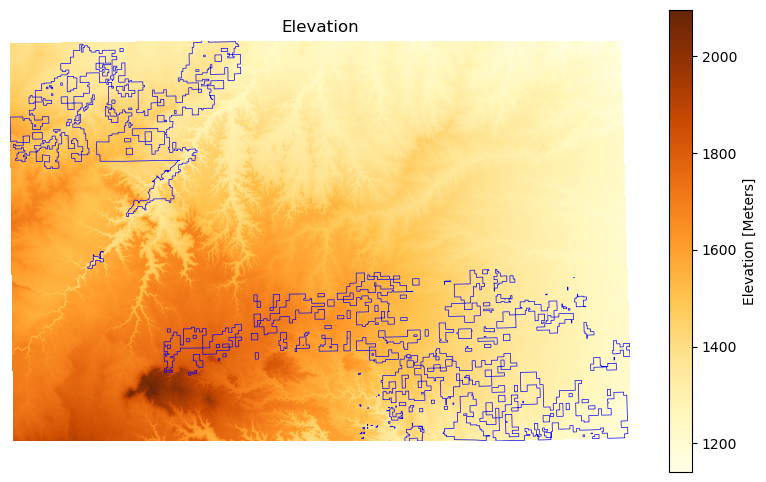

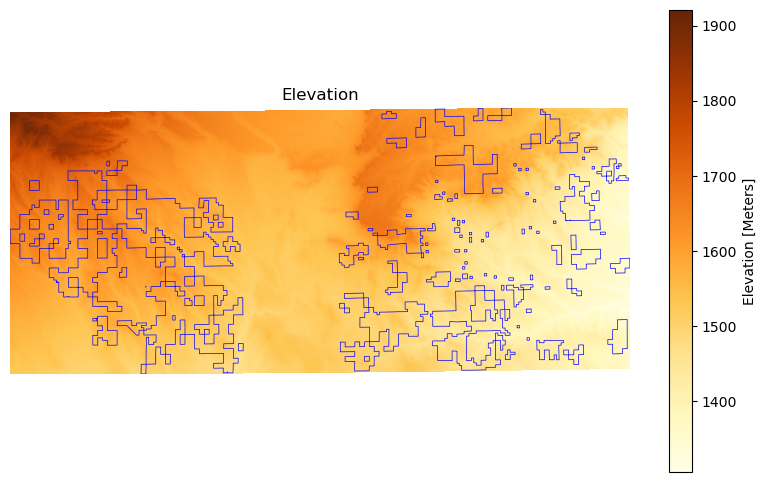

In [22]:
# Reset working directory to codespaces
os.chdir(owd)

# Create Comanche Elevation Plot
comanche_elev_fig, comanche_elev_ax1 = plt.subplots(figsize=(10, 6))
comanche_elev_da.plot(ax=comanche_elev_ax1, cmap='YlOrBr')
select_grassland_utm_gdf.loc[['Comanche National Grassland']].plot(ax=comanche_elev_ax1, facecolor="none", 
              edgecolor='blue', linewidth=.5)
plt.title("Elevation")
plt.axis('off')
comanche_elev_fig.savefig("comanche_elev_plt.png", bbox_inches='tight', dpi = 100)

# Create Pawnee Elevation Plot
pawnee_elev_fig, pawnee_elev_ax1 = plt.subplots(figsize=(10, 6))
pawnee_elev_da.plot(ax=pawnee_elev_ax1, cmap='YlOrBr')
select_grassland_utm_gdf.loc[['Pawnee National Grassland']].plot(ax=pawnee_elev_ax1, facecolor="none", 
              edgecolor='blue', linewidth=.5)
plt.title("Elevation")
plt.axis('off')
pawnee_elev_fig.savefig("pawnee_elev_plt.png", bbox_inches='tight', dpi = 100)

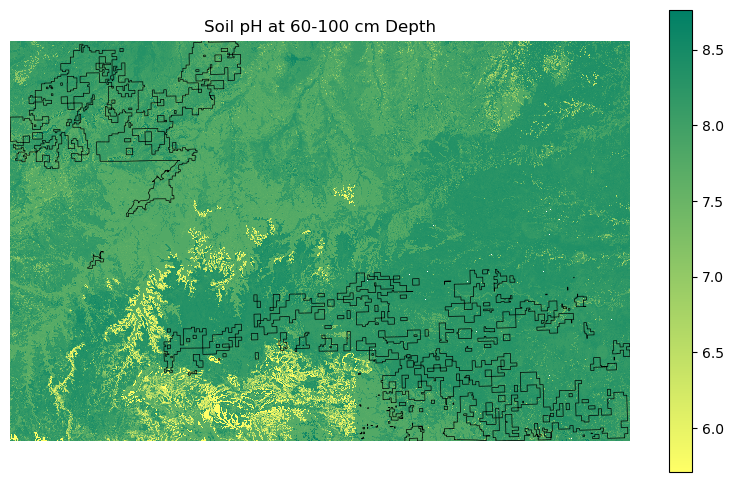

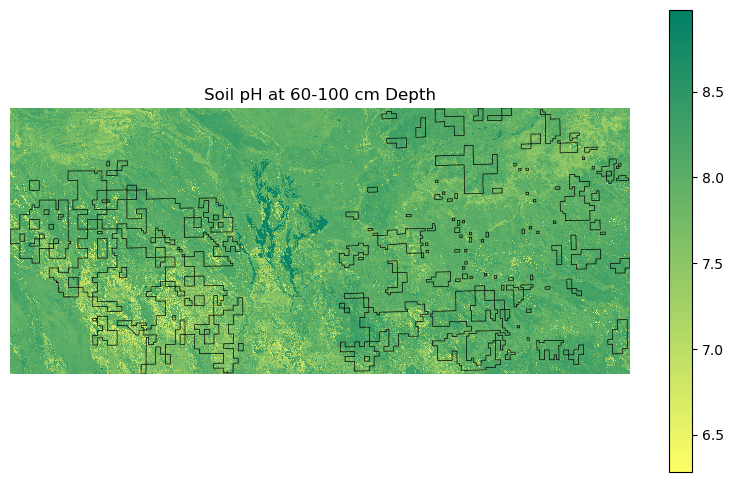

In [23]:
# Create Comanche pH Plot
comanche_pH_fig, comanche_pH_ax1 = plt.subplots(figsize=(10, 6))
comanche_pH_da.plot(ax=comanche_pH_ax1, cmap="summer_r")
(
    select_grassland_utm_gdf.loc[["Comanche National Grassland"]].plot(
        ax=comanche_pH_ax1, facecolor="none", edgecolor="black", 
        linewidth=0.5
    )
)
plt.title("Soil pH at 60-100 cm Depth")
plt.axis("off")
comanche_pH_fig.savefig("comanche_pH_plt.png", bbox_inches="tight", dpi=100)

# Create Pawnee Elevation Plot
pawnee_pH_fig, pawnee_pH_ax1 = plt.subplots(figsize=(10, 6))
pawnee_pH_da.plot(ax=pawnee_pH_ax1, cmap="summer_r")
select_grassland_utm_gdf.loc[["Pawnee National Grassland"]].plot(
    ax=pawnee_pH_ax1, facecolor="none", edgecolor="black", linewidth=0.5
)
plt.title("Soil pH at 60-100 cm Depth")
plt.axis("off")
pawnee_pH_fig.savefig("pawnee_pH_plt.png", bbox_inches="tight", dpi=100)

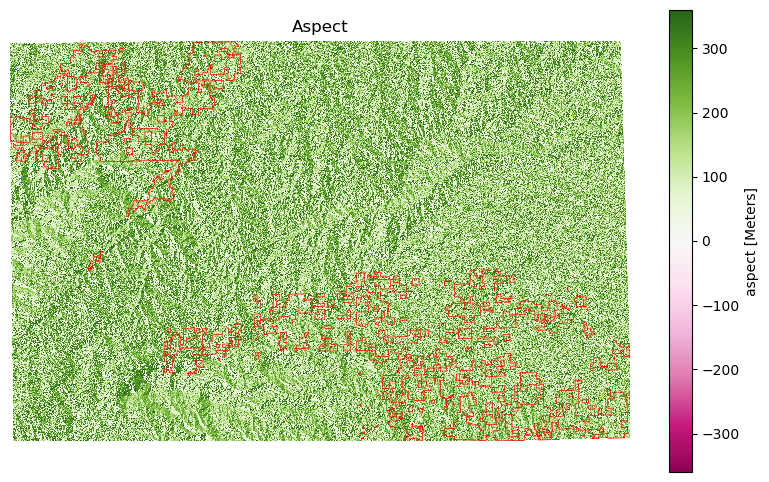

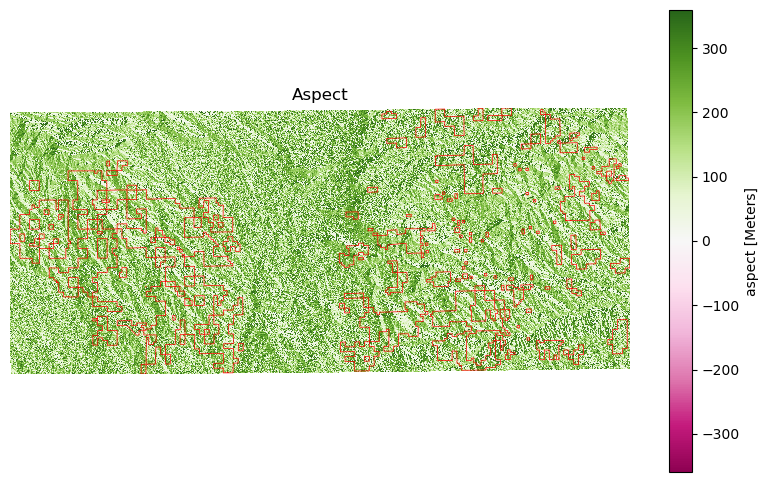

In [24]:
# Create Comanche Aspect Plot
comanche_aspect_fig, comanche_aspect_ax1 = plt.subplots(figsize=(10, 6))
comanche_aspect_da.plot(ax=comanche_aspect_ax1, cmap="PiYG")
(
    select_grassland_utm_gdf.loc[["Comanche National Grassland"]].plot(
        ax=comanche_aspect_ax1, facecolor="none", edgecolor="red", 
        linewidth=0.5
    )
)
plt.title("Aspect")
plt.axis("off")
comanche_aspect_fig.savefig("comanche_aspect_plt.png", bbox_inches="tight", dpi=100)

# Create Pawnee Elevation Plot
pawnee_aspect_fig, pawnee_aspect_ax1 = plt.subplots(figsize=(10, 6))
pawnee_aspect_da.plot(ax=pawnee_aspect_ax1, cmap="PiYG")
select_grassland_utm_gdf.loc[["Pawnee National Grassland"]].plot(
    ax=pawnee_aspect_ax1, facecolor="none", edgecolor="red", linewidth=0.5
)
plt.title("Aspect")
plt.axis("off")
pawnee_aspect_fig.savefig("pawnee_aspect_plt.png", bbox_inches="tight", dpi=100)

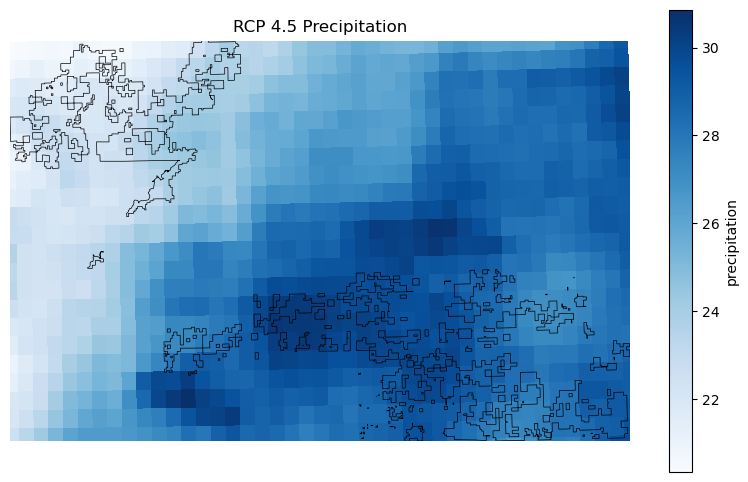

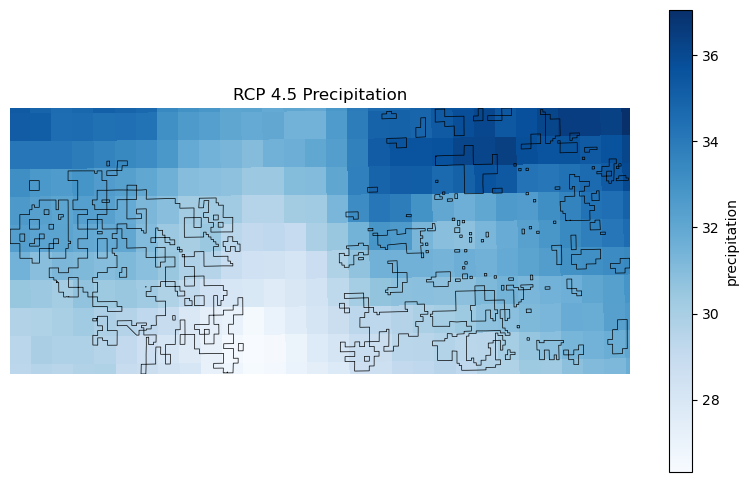

In [25]:
# Create Comanche Aspect Plot
comanche_rcp45_fig, comanche_rcp45_ax1 = plt.subplots(figsize=(10, 6))
comanche_CCSM4_rcp45_da.mean('time').plot(ax=comanche_rcp45_ax1, cmap="Blues")
(
    select_grassland_utm_gdf.loc[["Comanche National Grassland"]].plot(
        ax=comanche_rcp45_ax1, facecolor="none", edgecolor="black", 
        linewidth=0.5
    )
)
plt.title("RCP 4.5 Precipitation")
plt.axis("off")
comanche_rcp45_fig.savefig("comanche_rcp45_plt.png", bbox_inches="tight", dpi=100)

# Create Pawnee Elevation Plot
pawnee_rcp45_fig, pawnee_rcp45_ax1 = plt.subplots(figsize=(10, 6))
pawnee_CCSM4_rcp45_da.mean('time').plot(ax=pawnee_rcp45_ax1, cmap="Blues")
select_grassland_utm_gdf.loc[["Pawnee National Grassland"]].plot(
    ax=pawnee_rcp45_ax1, facecolor="none", edgecolor="black", linewidth=0.5
)
plt.title("RCP 4.5 Precipitation")
plt.axis("off")
pawnee_rcp45_fig.savefig("pawnee_rcp45_plt.png", bbox_inches="tight", dpi=100)